## Исследование данных об укусах собак в Нью-Йорке.

В нашем распоряжении набор данных, содержащий исторические данные за 2015-2022 гг. о зарегистрированных в Нью-Йорке укусах собак.

Данные предоставлены департаментом здравоохранения и психической гигиены города Нью-Йорка (DOHMH). Данные собираются из отчетов, полученных онлайн, по почте, факсу или по телефону в 311 или в NYC DOHMH Animal Bite Unit. Каждая запись представляет собой отдельный случай укуса собаки. Информация о породе, возрасте, поле и статусе стерилизации или кастрации не была проверена DOHMH и указана только в том виде, в котором она была сообщена DOHMH. Пустое место в наборе данных означает, что данные отсутствуют.


**Цель исследования**
* Выявить районы города, где проблема с нападениями собак стоит наиболее остро
* Проверить гипотезу, что сезонность влияет на число укусов
* Выяснить агрессивные породы

**Описание данных**

* `UniqueID` - уникальный номер случая
* `DateOfBite` - дата случая
* `Species` - биологический вид животного
* `Breed` - порода
* `Age` - возраст
* `Gender` - пол
* `SpayNeuter` - статус стерилизации или кастрации
* `Borough` - <a href="https://ru.wikipedia.org/wiki/%D0%91%D0%BE%D1%80%D0%BE_(%D0%9D%D1%8C%D1%8E-%D0%99%D0%BE%D1%80%D0%BA)">Боро (район) Нью-Йорка</a>
* `ZipCode` - ZIP-код

**План исследования**

Данные мы получили из файла, предоставленного DOHMH Animal Bite Unit. О качестве данных пока ничего не известно.
Поэтому перед проведением исследовательского анализа и проверкой гипотез нам понадобится обзор данных.

Таким образом, исследование пройдёт в несколько этапов:

1 — Обзор данных\
2 — Предобработка данных\
3 — Исследовательский анализ\
4 — Общий вывод


### Загрузка данных и изучение общей информации

In [1]:
#импорт библиотек Python
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import numpy as np
import seaborn as sns
import warnings
from IPython.display import display_html 

In [2]:
warnings.filterwarnings('ignore')#отключаем предупреждения об изменениях в библиотеках
sns.set_palette("Set2")#задаем цвета для библиотеки seaborn
data = pd.read_csv('DOHMH_Dog_Bite_Data.csv')#сохраняем данные в переменную data

Выведем первые 5 строк таблицы на экран и применим метод info()

In [3]:
display(data.head())
data.info()

,UniqueID,DateOfBite,Species,Breed,Age,Gender,SpayNeuter,Borough,ZipCode
0,1,January 01 2018,DOG,UNKNOWN,NaN,U,False,Brooklyn,11220
1,2,January 04 2018,DOG,UNKNOWN,NaN,U,False,Brooklyn,NaN
2,3,January 06 2018,DOG,Pit Bull,NaN,U,False,Brooklyn,11224
3,4,January 08 2018,DOG,Mixed/Other,4,M,False,Brooklyn,11231
4,5,January 09 2018,DOG,Pit Bull,NaN,U,False,Brooklyn,11224


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26127 entries, 0 to 26126
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   UniqueID    26127 non-null  int64 
 1   DateOfBite  26127 non-null  object
 2   Species     26127 non-null  object
 3   Breed       23864 non-null  object
 4   Age         12868 non-null  object
 5   Gender      26127 non-null  object
 6   SpayNeuter  26127 non-null  bool  
 7   Borough     26127 non-null  object
 8   ZipCode     18960 non-null  object
dtypes: bool(1), int64(1), object(7)
memory usage: 1.6+ MB


#### Промежуточный вывод

* часть столбцов, например `UniqueID` и `Species`, `ZipCode` для исследования не нужны. Можно удалить его из датафрейма
* в столбцах `Breed`, `Age`, `ZipCode` есть многочисленные пропуски
* названия столбцов имеют прописные буквы, лучше привести все названия к змеиному регистру 
* следует изменить тип столбца `DateOfBite`. Тип object поменяем на datetime64
* следует проверить датасет на наличия явных и скрытых дубликатов

Ниже удалим ненужные столбцы, уточним наличие дубликатов в строках, поправим названия столбцов и типы данных, а также изучим столбцы, содержащие пропуски.

### Предобработка данных

#### Поиск дубликатов

Сначала проверим датасет на наличие полностью повторяющихся строк:

In [4]:
display(data.duplicated().sum())

0

Таких строк нет, теперь перейдем к поиску скрытых дубликатов:

Скрытые дубликаты могут находиться в строковых столбцах `borough`, `gender` и `breed`.

Начнем со столбца `Borough`


In [5]:
display(data['Borough'].value_counts())#подсчитываем уникальные значения в столбце

Borough
Queens           6693
Manhattan        6081
Brooklyn         5698
Bronx            4375
Staten Island    2140
Other            1140
Name: count, dtype: int64

1140 строк со значением `Other` (англ. «другие»). Так как в Нью-Йорке всего 5 районов, можно предположить, что в эту категорию попали случаи, произошедшие либо за пределами города, либо локация была неизвестна. Так или иначе, отфильтруем эти строки, чтобы оставить информацию только по районам. В остальном названия районов написаны верно

In [6]:
data = data.query('Borough != "Other"')#удаляем лишние строки

Теперь проверим столбец `Gender`

In [7]:
data['Gender'].unique().tolist()#выводим на экран уникальные значения столбца 'Gender'

['U', 'M', 'F']

В столбце всего три значения. Скрытых дубликатов нет.

Теперь проверим столбец `Breed`

In [8]:
len(data['Breed'].unique())#считаем уникальные значения столбца 'Breed'

1702

Всего в датасете встречаются 1702 уникальных названия пород

Посмотрим какие из них встречаются чаще всего:

In [9]:
#подсчитываем уникальные значения в столбце и выводим на экран 10 самых часто встречающихся
data['Breed'].value_counts().head(10)

Breed
Pit Bull                                4450
UNKNOWN                                 3217
Shih Tzu                                 768
Chihuahua                                711
German Shepherd                          681
American Pit Bull Mix / Pit Bull Mix     551
Mixed/Other                              530
Yorkshire Terrier                        524
American Pit Bull Terrier/Pit Bull       521
MIXED                                    485
Name: count, dtype: int64

In [10]:
#подсчитываем уникальные значения в столбце и выводим на экран 10 редко встречающихся
data['Breed'].value_counts().tail(10)

Breed
LABRADOR/SHAR-PEI MIX         1
RAT TERRIER / SHIH TZU MIX    1
HOUND / LAB MIX               1
DOBERMAN AND LABRADOR         1
MALTESE / WESTIE MIX          1
PITBULL BOXER MIX             1
ROTTWEILER/HUSKY MIX          1
MALTI-POO                     1
JACK RUSSELL/MALTESE MIX      1
SHIH TZU / POMERANIAN         1
Name: count, dtype: int64

**Наблюдения**

В столбце собраны сырые данные. 

* Названия пород написаны разными способами (пример — `American Pit Bull Mix / Pit Bull Mix`  и `American Pit Bull Terrier/Pit Bull`), с опечатками и в разном регистре
* Второе по частоте значение — `UNKNOWN` (англ. «неизвестный»), также в топ 20 встречается `MIXED`, который обозначает любого метиса.

Пока что оставим этот столбец как есть и вернемся к нему позднее.

#### Удаление лишних столбцов

Для исследования не понадобятся следующие столбцы:

`UniqueID` — дублирует внутреннюю нумерацию в датафрейме\
`Species` — в данных речь идет только о собаках, так что вид — всегда `DOG`\
`ZipCode` - нас интересуют только распределения по районам(боро)\
`Age` — в этом столбце есть многочисленные пропуски (только 12 868 из 26 127 строк заполнены). Также, учитывая, что данные для этого столбца оцениваются приблизительно, сложно использовать эти данные для каких-либо выводов.

In [11]:
#удаление лишних столбцов
data = data.drop(columns=['UniqueID','Species','ZipCode','Age'])

#### Приведение названий столбцов к единому регистру

In [12]:
#приведение названий к змеиному регистру
data.columns = data.columns.str.lower()
data = data.rename(columns={'dateofbite': 'date_of_bite','spayneuter': 'spay_or_neuter'})

Выведем первые 5 строк получившейся таблицы на экран

In [13]:
data.head()

,date_of_bite,breed,gender,spay_or_neuter,borough
0,January 01 2018,UNKNOWN,U,False,Brooklyn
1,January 04 2018,UNKNOWN,U,False,Brooklyn
2,January 06 2018,Pit Bull,U,False,Brooklyn
3,January 08 2018,Mixed/Other,M,False,Brooklyn
4,January 09 2018,Pit Bull,U,False,Brooklyn


#### Изменение типов данных и добавление новых столбцов

* Поменяем столбцу `date_of_bite` тип на datetime64

Добавим несколько столбцов на основе столбца `date_of_bite`:
* `month_of_bite` — название месяца в виде сокращения
* `month_of_bite_number` — месяц случая в виде числа
* `year_of_bite` - год случая

In [14]:
#преобразование типа данных
data['date_of_bite'] = pd.to_datetime(data['date_of_bite'])

In [15]:
#добавление новых столбцов
data['month_of_bite'] = data['date_of_bite'].dt.strftime('%b')
data['month_of_bite_number'] = pd.DatetimeIndex(data['date_of_bite']).month 
data['year_of_bite'] = pd.DatetimeIndex(data['date_of_bite']).year 

data.head()

,date_of_bite,breed,gender,spay_or_neuter,borough,month_of_bite,month_of_bite_number,year_of_bite
0,2018-01-01,UNKNOWN,U,False,Brooklyn,Jan,1,2018
1,2018-01-04,UNKNOWN,U,False,Brooklyn,Jan,1,2018
2,2018-01-06,Pit Bull,U,False,Brooklyn,Jan,1,2018
3,2018-01-08,Mixed/Other,M,False,Brooklyn,Jan,1,2018
4,2018-01-09,Pit Bull,U,False,Brooklyn,Jan,1,2018


#### Работа с пропусками


In [16]:
data.info()#применим к обновленной таблице метод info()

<class 'pandas.core.frame.DataFrame'>
Index: 24987 entries, 0 to 26126
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   date_of_bite          24987 non-null  datetime64[ns]
 1   breed                 22861 non-null  object        
 2   gender                24987 non-null  object        
 3   spay_or_neuter        24987 non-null  bool          
 4   borough               24987 non-null  object        
 5   month_of_bite         24987 non-null  object        
 6   month_of_bite_number  24987 non-null  int32         
 7   year_of_bite          24987 non-null  int32         
dtypes: bool(1), datetime64[ns](1), int32(2), object(4)
memory usage: 1.4+ MB


В датасете остался только один столбец, содержащий пропуски — `breed`.
Выше мы выяснили, что одно из самых частых значений в столбце — `UNKNOWN` (англ. «неизвестный»), которое является в данном случае синонимом пропуска данных.
Заменим на него все пропуски в столбце.

In [17]:
#меняем пропуски на UNKNOWN
data['breed'] = data['breed'].fillna(value='UNKNOWN')
#считаем пропуски в столбце breed
data['breed'].isna().sum()

0

#### Промежуточный вывод
Мы подготовили данные к работе:

* удалили ненужные столбцы
* привели названия к единому написанию
* проверили датасет на пропуски и заполнили пропуски подходящими значениями
* проверили датасет на наличие явных и скрытых дубликатов, обнаружили проблемный столбец с породами собак
* изменили тип данных в столбце date_of_bite на подходящий и добавили на его основе дополнительные столбцы с месяцем и годом случая.

### Анализ сезонности

Проверим временной период, который охватывает датасет:

In [18]:
print ('Самая ранняя дата в датасете:',data['date_of_bite'].min())
print ('Самая поздняя дата в датасете:',data['date_of_bite'].max())

Самая ранняя дата в датасете: 2015-01-01 00:00:00
Самая поздняя дата в датасете: 2022-12-31 00:00:00


Как и указано в описании данных — датасет охватывает 8 лет. С 1 января 2015 года по 31 декабря 2022 г.

Сгруппируем случаи по годам и месяцам:

In [19]:
#создаем сводную таблицу с группировкой по годам
bites_per_year = data.groupby('year_of_bite')['date_of_bite'].count().to_frame().reset_index()
bites_per_year.columns = ['year_of_bite','total']

#создаем сводную таблицу с группировкой по месяцам
bites_per_month = data.pivot_table(index=['month_of_bite_number','month_of_bite'],
                                          values='date_of_bite',
                                          aggfunc=['count']).droplevel('month_of_bite_number', axis=0)
#переименуем столбец и сбросим индекс
bites_per_month.columns = ['total']
bites_per_month = bites_per_month.reset_index()

#выведем обе таблицы на экран
df1_styler = bites_per_year.style.set_table_attributes("style='display:inline'").set_caption('<b>Распределение случаев укусов собак по годам</b>')
df2_styler = bites_per_month.style.set_table_attributes("style='display:inline'").set_caption('<b>Распределение случаев укусов собак по месяцам</b>')
display_html(df1_styler._repr_html_()+15*'&nbsp' +df2_styler._repr_html_(), raw=True)

,year_of_bite,total
0,2015,3390
1,2016,3085
2,2017,3368
3,2018,3238
4,2019,3389
5,2020,2424
6,2021,2788
7,2022,3305
,month_of_bite,total
0,Jan,1613


In [20]:
#посчитаем среднее количество событий летом
summer_months = bites_per_month.sort_values(by='total',ascending=False)['total'][:3]
summer_months_mean = summer_months.sum()/3

#посчитаем среднее количество событий зимой
winter_months = bites_per_month.sort_values(by='total',ascending=False)['total'][-3:]
winter_months_mean = winter_months.sum()/3

#посчитаем разницу между количеством укусов летом и зимой в процентах
print('Разница между количеством укусов летом и зимой —',
      "{0:.2f}%".format(100 - round(winter_months_mean/summer_months_mean*100,2)))

Разница между количеством укусов летом и зимой — 34.50%


**Визуализируем полученные таблицы на графике**

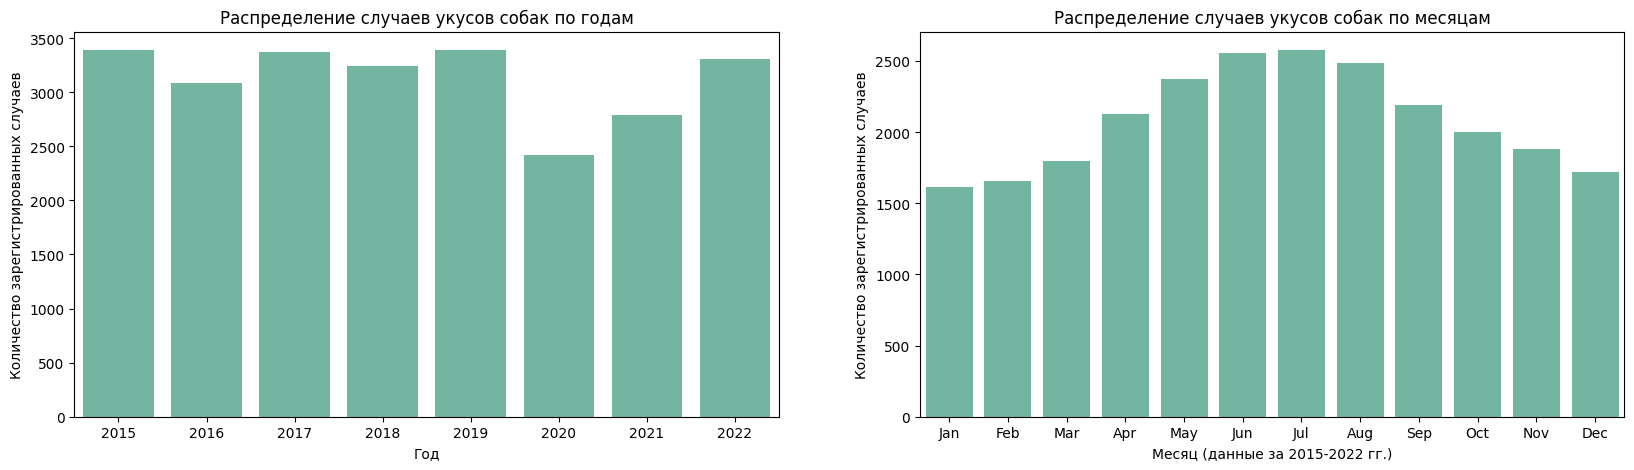

In [21]:
#создаем графики
fig, axes= plt.subplots(1, 2)
fig.set_size_inches(20, 5)

sns.barplot(ax=axes[0],data=bites_per_year, x='year_of_bite', y='total', errorbar=None)
axes[0].set_title('Распределение случаев укусов собак по годам')
axes[0].set_xlabel('Год')
axes[0].set_ylabel('Количество зарегистрированных случаев')

sns.barplot(ax=axes[1],data=bites_per_month, x='month_of_bite', y='total', errorbar=None)
axes[1].set_title('Распределение случаев укусов собак по месяцам')
axes[1].set_xlabel('Месяц (данные за 2015-2022 гг.)')
axes[1].set_ylabel('Количество зарегистрированных случаев');

#### Промежуточный вывод

* Меньше всего укусов зарегистрировано в 2020 и 2021 году. Возможно это связано с пандемией коронавируса и периодом ввода в городе правил самоизоляции. Это единственные года за исследуемый период, за которые наблюдалось менее 3000 случаев.
* Больше всего укусов зафиксировано в 2015 году (3390 случаев)
* Наблюдается выраженная сезонность событий: в зимние месяцы в среднем зафиксировано на 34.5% меньше случаев, чем в летние

### Распределение случаев по районам

Напомним, что в Нью-Йорке существуют пять административных округов (районов, боро):

1. `Manhattan` — Манхэттен 
2. `Brooklyn` — Бруклин
3. `Queens` — Куинс
4. `Bronx` — Бронкс
5. `Staten Island` — Статен-Айленд


Создадим сводную таблицу с группировкой по районам и месяцам: 

In [22]:
monthly_bites_by_borough = data.pivot_table(index=['month_of_bite_number','month_of_bite'],
                        columns='borough',
                                          values='date_of_bite',
                                          aggfunc=['count'])

monthly_bites_by_borough.columns = monthly_bites_by_borough.columns.droplevel()
monthly_bites_by_borough.index = monthly_bites_by_borough.index.droplevel()
monthly_bites_by_borough

borough,Bronx,Brooklyn,Manhattan,Queens,Staten Island
month_of_bite,,,,,
Jan,322,353,419,370,149
Feb,297,370,440,415,138
Mar,345,378,443,469,160
Apr,357,500,521,560,189
May,405,527,609,625,206
Jun,392,626,578,751,209
Jul,448,613,534,751,232
Aug,398,586,599,708,195
Sep,378,519,527,588,183


Визуализируем полученную таблицу на тепловой карте:

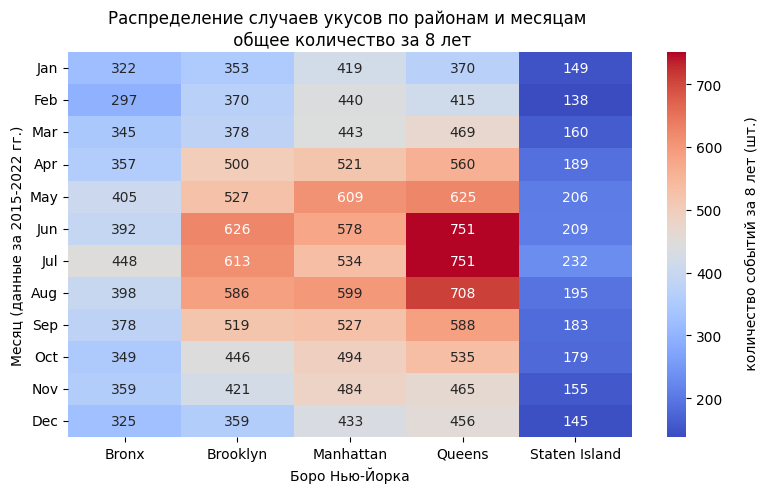

In [23]:
#создаем график
plt.figure(figsize=(20, 5))

sns.heatmap(
    monthly_bites_by_borough, ax=plt.subplot(1, 2, 1), cmap="coolwarm", annot=True, fmt='.0f',cbar_kws={'label': '\n количество событий за 8 лет (шт.)'}
)
plt.yticks(rotation=0)

#прописываем оси и названия
plt.title('Распределение случаев укусов по районам и месяцам \n общее количество за 8 лет')
plt.xlabel('Боро Нью-Йорка') 
plt.ylabel('Месяц (данные за 2015-2022 гг.)');

**Наблюдения:**

* Отчетливо видна сезонность случаев, которую мы отметили выше
* Менее всего событий происходит в районе Статен-Айленд, больше всего — в Куинс

Можем ли мы из этого предположить, что самым опасным по укусам является Куинс, а безопасным — Статен-Айленд? При расчете мы не брали в расчет населенность районов.
Ниже посчитаем количество укусов на жителя.

----

На <a href="https://en.wikipedia.org/wiki/Demographics_of_New_York_City#cite_note-41:~:text=New%20York%20City%27s%20five%20boroughs">странице Wikipedia</a> размещены данные о последней переписи в США за 2020 год. Возьмем данные из этого источника и запишем в переменную:

In [24]:
#создаем словарь с данными переписи в млн. чел
population = {
  "Bronx": 1.472654,
  "Brooklyn": 2.736074,
  "Manhattan": 1.694251,
   "Queens": 2.405464,
  "Staten Island": 0.495747 
}
population

{'Bronx': 1.472654,
 'Brooklyn': 2.736074,
 'Manhattan': 1.694251,
 'Queens': 2.405464,
 'Staten Island': 0.495747}

In [25]:
#создаем копию датасета monthly_bites_by_borough
bites_per_population = monthly_bites_by_borough.copy()

#делим значения в копии на соответствующее количество млн. жителей с округлением до 2-х знаков после запятой
for i in bites_per_population:
    bites_per_population[i] = round(bites_per_population[i]/population[i],2)

bites_per_population

borough,Bronx,Brooklyn,Manhattan,Queens,Staten Island
month_of_bite,,,,,
Jan,218.65,129.02,247.31,153.82,300.56
Feb,201.68,135.23,259.70,172.52,278.37
Mar,234.27,138.15,261.47,194.97,322.75
Apr,242.42,182.74,307.51,232.80,381.24
May,275.01,192.61,359.45,259.83,415.53
Jun,266.19,228.79,341.15,312.21,421.59
Jul,304.21,224.04,315.18,312.21,467.98
Aug,270.26,214.18,353.55,294.33,393.35
Sep,256.68,189.69,311.05,244.44,369.14


**Визуализируем новую таблицу на тепловой карте:**

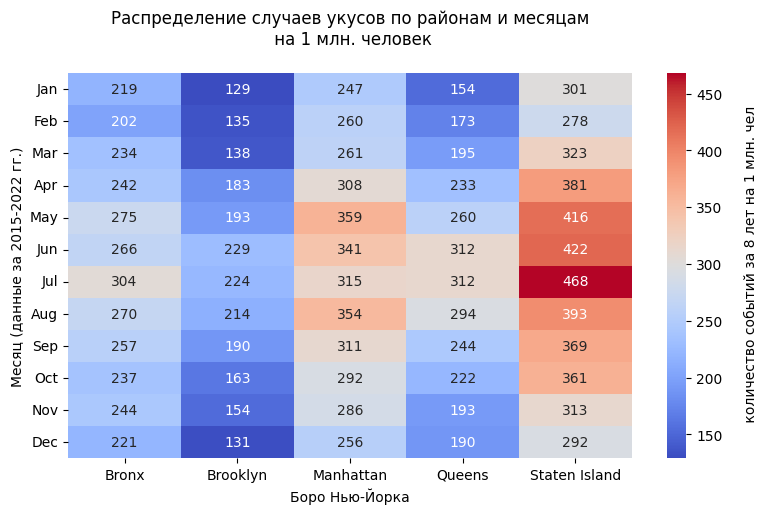

In [26]:
#создаем график
plt.figure(figsize=(20, 5))

sns.heatmap(
    bites_per_population, ax=plt.subplot(1, 2, 1),  cmap="coolwarm", annot=True, fmt='.0f',cbar_kws={'label': '\n количество событий за 8 лет на 1 млн. чел'}
)

plt.yticks(rotation=0)

#прописываем оси и названия
plt.title('Распределение случаев укусов по районам и месяцам\n на 1 млн. человек\n')
plt.xlabel('Боро Нью-Йорка') 
plt.ylabel('Месяц (данные за 2015-2022 гг.)');

Уточним сколько в среднем в год зарегистрировано укусов в районе-лидере Статен-Айленд.

In [27]:
#делим сумму столбца 'Staten Island' на 8 лет
bites_per_population['Staten Island'].sum()/8

539.59125

**Наблюдения:**

Ситуация изменилась. Так как в Статен-Айленд меньше всего жителей, район вышел на первое место по количеству событий на жителя (540 на 1 млн. человек в год)

#### Промежуточный вывод

* Больше всего событий на жителя происходит в Статен-Айленде
* Меньше всего — в Бруклине

### Поиск агрессивных пород

Напомним, что информацию о породе собаки, содержит столбец `breed`. Выше, на этапе предобработки данных, мы выяснили, что этот **столбец содержит сырые данные**, попробуем исправить их хотя бы частично, чтобы отследить основные тенденции

In [28]:
print('Количество уникальных названий пород до очистки —', len(data['breed'].unique().tolist()))

Количество уникальных названий пород до очистки — 1701


In [29]:
#приведем все названия к нижнему регистру
data['breed'] = data['breed'].str.lower()
#унифицируем написание смешанных пород
data['breed'] = data['breed'].str.replace(' x', '')
data['breed'] = data['breed'].str.replace(' / ', '/')
data['breed'] = data['breed'].str.replace('/ ', '/')
data['breed'] = data['breed'].str.replace(' /', '/')
data['breed'] = data['breed'].str.replace('mix/other', 'unknown')
data['breed'] = data['breed'].str.replace('mixed', 'unknown')
data['breed'] = data['breed'].str.replace('mixed/other', 'unknown')
data['breed'] = data['breed'].str.replace('mixed breed', 'unknown')
data['breed'] = data['breed'].str.replace('unknown breed', 'unknown')
data['breed'] = data['breed'].str.replace('unknown/other', 'unknown')

data['breed'] = data['breed'].str.replace('american pit bull terrier/pit bull', 'american pit bull/pit bull mix')
data['breed'] = data['breed'].str.replace('american pit bull mix/pit bull mix', 'american pit bull/pit bull mix')

print('Количество уникальных названий пород после очистки —', len(data['breed'].unique().tolist()))

Количество уникальных названий пород после очистки — 1521


Удалось избавиться от 180 дублей в названиях, но все ровно данные достаточно грязные, выведем, например, на экран варианты со словом 'german', так как в слове 'shepherd' (german shepherd — англ. «немецкая овчарка») часто допускаются ошибки или сокращения. Выведем на экран количество вариантов и первые 15 из них.

In [30]:
myvar = 'german'
display(data.loc[data['breed'].str.contains(myvar)]['breed'].unique().tolist()[:15])
display(len(data.loc[data['breed'].str.contains(myvar)]['breed'].unique().tolist()))

['german shepherd',
 'german shepherd crossbreed',
 'german shepherd/golden retriever',
 'german shepherd/labrador mix',
 'german pinscher',
 'german shep, pit bull & husky mix',
 'pit bull/german shepherd mix',
 'german shepherd/siberian husky mix',
 'german shepherd mix',
 'german sheperd/pitbull',
 'husky/german shepherd mix',
 'german shepher mix',
 'astralian cattle/german pointer mix',
 'golden retreiver/german shepherd',
 'german shepard mix']

50

Итак, с одними только немецкими овчарками встречаются 50 вариантов написания и смешанных пород.

Поэтому мы не можем делать какие-либо точные выводы из информации о породах в датафрейме.
Но можно взглянуть на топ пород по частоте:

In [31]:
#выведем топ 20 чаще всего встречающихся пород на экран

breed_top = data['breed'].value_counts().head(21)[1:]
breed_top = breed_top.to_frame().reset_index()
round(data['breed'].value_counts(normalize=True).head(20)*100,2)

breed
unknown                           27.01
pit bull                          17.86
american pit bull/pit bull mix     4.29
shih tzu                           3.14
chihuahua                          2.86
german shepherd                    2.73
yorkshire terrier                  2.11
maltese                            1.64
rottweiler                         1.42
siberian husky                     1.38
labrador retriever                 1.18
poodle, standard                   1.11
bull dog                           0.98
jack russ                          0.78
terrier                            0.76
cocker spaniel                     0.68
labrador retriever crossbreed      0.66
beagle                             0.64
golden retriever                   0.60
shiba inu                          0.56
Name: proportion, dtype: float64

**Наблюдения:**

* в 17% случаев указана порода `pit bull` (англ. «питбультерьер»), также следующий по популярности (4% — метис этой породы)

Даже с учетом того, что данные в столбце не соответствуют идеалу, можно предположить, что эта порода лидирует с большим отрывом.
На всякий случай уточним топ пород в Нью-Йорке.

Данные за 2021 г. есть на сайте <a href="https://www.akc.org/expert-advice/news/most-popular-dog-breeds-city-2021/">Американского клуб собаководства (англ. American Kennel Club) </a>— некоммерческой кинологической организации, ведущей реестр чистокровных пород собак. В соответствии с информацией этой организации топ 5 пород в Нью-Йорке:

1 — `French Bulldog` — французский бульдог\
2 — `Poodle` — пудель\
3 — `Golden Retriever` — золотистый ретривер\
4 — `Bulldog` — английский бульдог\
5 — `Labrador Retriever` — лабрадор ретривер

Таким образом питбули являются лидерами по нападениям, несмотря на то, что их нет в топ 5 популярных пород.


**Посмотрим деление по породам на графике(для топ 20 чаще всего встречающихся пород, исключая `unknown`)**

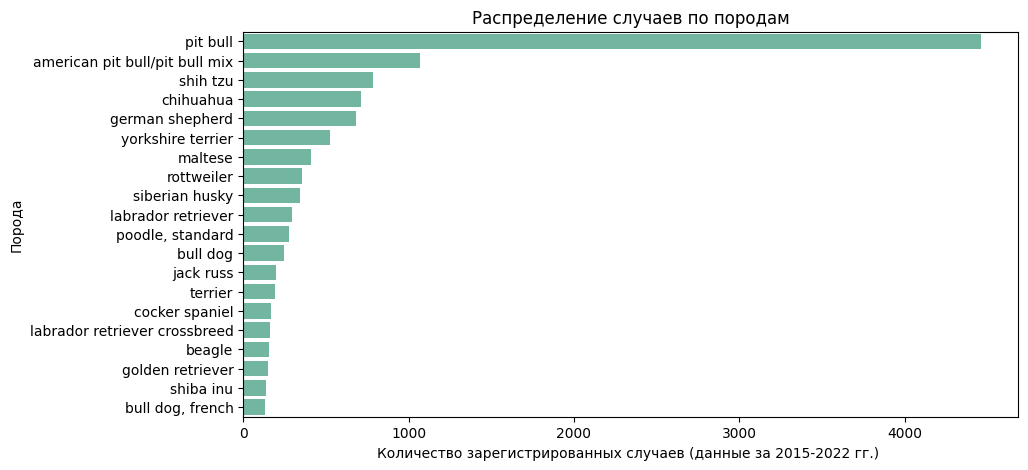

In [32]:
#создаем график
plt.figure(figsize=(10, 5))
sns.barplot(data=breed_top, x='count', y='breed', errorbar=None)

#прописываем оси и названия
plt.title('Распределение случаев по породам')
plt.xlabel('Количество зарегистрированных случаев (данные за 2015-2022 гг.) ') 
plt.ylabel('Порода');

**Уточним, распределение случаев по полу животного**

In [33]:
data['gender'].value_counts(normalize=True)*100

gender
U    47.728819
M    37.803658
F    14.467523
Name: proportion, dtype: float64

#### Промежуточный вывод

Мы проанализировали столбцы `breed` и `gender` и сделали следующие выводы:

* в случаях, когда пол животного был указан, кобели встречаются в 2,64 раза чаще
* питбули лидируют по количеству случаев с достаточно высоким отрывом (14% всех нападений)
* выяснили, что для более точного изучения агрессивности пород, данные слишком загрязнены ошибками и дублями, также у нас нет более точной информации по количеству в городе собак каждой из пород.

### Итоги исследования


В ходе исследования:

**`В рамках предобработки данных:`**

* удалили ненужные столбцы и привели названия к единому написанию
* проверили датасет на пропуски и заполнили пропуски подходящими значениями
* проверили датасет на наличие явных и скрытых дубликатов, обнаружили проблемный столбец с породами собак
* изменили тип данных в столбце date_of_bite на подходящий и добавили на его основе дополнительные столбцы с месяцем и годом случая.

**`Провели исследовательский анализ и сделали следующие выводы:`**

* **Гипотеза, что сезонность влияет на количество нападений подтвердилась.** В зимние месяцы в среднем зафиксировано на 34.5% меньше случаев, чем в летние
* Выяснили **район-лидер по количеству укусов —  Статен-Айленд**. Здесь зарегистрировано в среднем 540 нападений на 1 млн. жителей в год
* В случаях, когда пол животного был указан, **кобели встречаются в 2,64 раза чаще сук**
* **Питбультерьеры лидируют по количеству случаев с достаточно высоким отрывом (14% всех нападений)**, но более детальные выводы по имеющимся данным мы сделать не можем


Публикация результатов анализа может способствовать повышению осведомлённости людей о рисках, связанных с укусами собак, и стимулировать их к более ответственному обращению с животными.